In [1]:

############################### Import libraries ###############################

import os
import glob
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import numpy as np


################################## set device ##################################

print("============================================================================================")


# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
    
print("============================================================================================")



Device set to : NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:



################################## PPO Policy ##################################


class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Tanh()
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )

        
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )
        
    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self):
        raise NotImplementedError
    

    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()
    

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)
            
            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):
        
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        print("--------------------------------------------------------------------------------------------")


    def select_action(self, state):
        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device).unsqueeze(0)  # Ensure state is the correct shape
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device).unsqueeze(0)  # Ensure state is the correct shape
                action, action_logprob, state_val = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.item()



    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()
        

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        
        
       



In [3]:
################################## FEM Analysis ##################################

import time
import numpy as np                                                # for dense matrix ops
import matplotlib.pyplot as plt                                   # for plotting
import autograd, autograd.core, autograd.extend, autograd.tracer  # for adjoints
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    # sparse matrices
import nlopt   


def causeway_bridge(width=128, height=128, density=0.08, deck_level=0.2):
  """A bridge supported by columns at a regular interval."""
  x_ix, y_ix = 0, 1
  normals = np.zeros((width + 1, height + 1, 2))
  normals[-1, -1, y_ix] = 1
  normals[-1, :, x_ix] = 1
  normals[0, :, x_ix] = 1

  forces = np.zeros((width + 1, height + 1, 2))
  forces[:, round(height * (1 - deck_level)), y_ix] = -1 / width
  return normals, forces, density
  
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=0.4):  # Manage the problem setup parameters
  width = normals.shape[0] - 1
  height = normals.shape[1] - 1
  fixdofs = np.flatnonzero(normals.ravel())
  alldofs = np.arange(2 * (width + 1) * (height + 1))
  freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
  params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 5, 'print_every': 20}
  return ObjectView(params)

def mbb_beam(width=80, height=25, density=0.4, y=1, x=0):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[-1, -1, y] = 1
    normals[0, :, x] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[0, 0, y] = -1
    return normals, forces, density
#'''
  

def mbb_beam(width=6, height=6, density=0.4, y=1, x=0):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[-1, -1, y] = 1
    normals[0, :, x] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[0, 0, y] = -1
    forces[height//2, width, y] = -1
    return normals, forces, density

def mbb_beam2(width=6, height=6, density=0.4, y=1, x=0):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    
    normals[0, 0, :] = 1   
    normals[0, width, :] = 1  
    normals[0, width // 2, :] = 1  
    
    forces = np.zeros((width + 1, height + 1, 2))
    
    forces[-1, :, y] = -1 / width
    
    return normals, forces, density
#'''
def _get_solver(a_entries, a_indices, size, sym_pos):
  # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
  a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
  return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
  solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
  return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
  def jvp(grad_ans):
    lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                        grad_ans, sym_pos)
    i, j = a_indices
    return -lambda_[i] * ans[j]
  return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
  return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
  del ans, x  # unused
  return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)
def young_modulus(x, e_0, e_min, p=3):
  return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=False):
  x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
  return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
  return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)
def objective_calc(x, args, volume_contraint=False, use_filter=True):
  kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
  x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
  ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
  u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
  c      = compliance_calc(x_phys, u, ke, **kwargs)
  #print("x_phys= ",  x_phys)
  #print("compliance = ", c)
  return c
def compliance_calc(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
  nely, nelx = x_phys.shape
  ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

  n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
  n2 = (nely+1)*(elx+1) + (ely+0)
  n3 = (nely+1)*(elx+1) + (ely+1)
  n4 = (nely+1)*(elx+0) + (ely+1)
  all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
  u_selected = u[all_ixs]  # select from u matrix

  ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
  ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
  C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
  return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
  k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
  return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])
def get_k(stiffness, ke):
  # Constructs sparse stiffness matrix k (used in the displace fn)
  # First, get position of the nodes of each element in the stiffness matrix
  nely, nelx = stiffness.shape
  ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
  ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

  n1 = (nely+1)*(elx+0) + (ely+0)
  n2 = (nely+1)*(elx+1) + (ely+0)
  n3 = (nely+1)*(elx+1) + (ely+1)
  n4 = (nely+1)*(elx+0) + (ely+1)
  edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
  edof = edof.T[0]
  x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
  y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

  # make the global stiffness matrix K
  kd = stiffness.T.reshape(nelx*nely, 1, 1)
  value_list = (kd * anp.tile(ke, kd.shape)).flatten()
  return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
  # Displaces the load x using finite element techniques (solve_coo=most of runtime)
  stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
  k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

  index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)
  
  u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
  u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
  return u_values[index_map]
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
  index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
  keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
  # Now we index an indexing array that is being indexed by the indices of k
  i = index_map[k_ylist][keep]
  j = index_map[k_xlist][keep]
  return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
  inverse_perm = np.zeros(len(indices), dtype=anp.int64)
  inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
  return inverse_perm
def fast_stopt(args, x=None, verbose=True):
  if x is None:
    x = anp.ones((args.nely, args.nelx)) * args.density  # init mass

  reshape = lambda x: x.reshape(args.nely, args.nelx)
  objective_fn = lambda x: objective_calc(reshape(x), args) # don't enforce mass constraint here
  constraint = lambda params: mean_density(reshape(params), args) - args.density

  def wrap_autograd_func(func, losses=None, frames=None):
    def wrapper(x, grad):
      if grad.size > 0:
        value, grad[:] = autograd.value_and_grad(func)(x)
      else:
        value = func(x)
      if losses is not None:
        losses.append(value)
      if frames is not None:
        frames.append(reshape(x).copy())
        if verbose and len(frames) % args.print_every == 0:
          print('step {}, loss {:.2e}, t={:.2f}s'.format(len(frames), value, time.time()-dt))
      return value
    return wrapper

  losses, frames = [], [] ; dt = time.time()
  print('Optimizing a problem with {} nodes'.format(len(args.forces)))
  opt = nlopt.opt(nlopt.LD_MMA, x.size)
  opt.set_lower_bounds(0.0) ; opt.set_upper_bounds(1.0)
  opt.set_min_objective(wrap_autograd_func(objective_fn, losses, frames))

  opt.add_inequality_constraint(wrap_autograd_func(constraint), 1e-8)
  opt.set_maxeval(args.opt_steps + 1)
  opt.optimize(x.flatten())
  return np.array(losses), reshape(frames[-1]), np.array(frames), constraint(frames[-1])
  #return objective(x, args), constraint(x)  #losses[-1]

def optim( args, x=None, verbose = True):
    if x is None:
        x = anp.ones((args.nely, args.nelx)) * args.density  # init mass
    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective_calc(reshape(x), args) # don't enforce mass constraint here
    constraint = lambda params: mean_density(reshape(params), args) 
    return objective_calc(x, args), constraint(x)  #losses[-1]

In [4]:
################################## GYM Enviroment ##################################


import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt


import optuna

class BeamOptimizationEnv(gym.Env):
    def __init__(self, width=6, height=6, density=0.4):
        super(BeamOptimizationEnv, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.width = width
        self.height = height
        self.density = density
        self.max_steps = self.width * self.height
        self.action_space = gym.spaces.Discrete(self.width * self.height)
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(self.width * self.height,), dtype=np.float32)
        self.previous_constraint = 1.0
        self.significant_improvement = 10
        self.state = torch.ones((self.height, self.width), dtype=torch.float32, device=self.device) 
        self.visited = torch.zeros((self.height * self.width), dtype=bool, device=self.device)
        self.visited_cells = set()
        normals, forces, _ = mbb_beam(width, height, density)
        self.normals = torch.tensor(normals, dtype=torch.float32, device=self.device)
        self.forces = torch.tensor(forces, dtype=torch.float32, device=self.device)
        self.args = get_args(self.normals.cpu().numpy(), self.forces.cpu().numpy(), density)
        self.current_compliance = float('inf')
        self.previous_compliance = 10
        self.current_step = 0
        self.reward = 0

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        self.state = torch.ones((self.width * self.height), dtype=torch.float32, device=self.device) 
        self.current_step = 0
        self.visited = torch.zeros((self.width * self.height), dtype=bool)
        self.visited_cells = set()
        self.current_compliance = float('inf')
        self.previous_compliance = 10
        self.reward = 0
        return self.state.cpu().numpy()  # Return as numpy arra

    def is_strongly_connected(self, state, threshold=0.8):
        grid = state.cpu().numpy().reshape(self.height, self.width)
        for i in range(self.height - 1):
            for j in range(self.width - 1):
                if grid[i, j] > threshold and grid[i + 1, j + 1] > threshold:
                    if grid[i, j + 1] <= threshold and grid[i + 1, j] <= threshold:
                        return False
                if grid[i + 1, j] > threshold and grid[i, j + 1] > threshold:
                    if grid[i, j] <= threshold and grid[i + 1, j + 1] <= threshold:
                        return False
        return True

    def is_connected(self, state, threshold=0.8):
        grid = state.cpu().numpy().reshape(self.width, self.height)
        n = grid.shape[0]
        visited = np.zeros_like(grid, dtype=bool)
        stack = []

        for i in range(n):
            for j in range(n):
                if grid[i, j] > threshold:
                    stack.append((i, j))
                    break
            if stack:
                break

        while stack:
            x, y = stack.pop()
            if visited[x, y]:
                continue
            visited[x, y] = True
            for dx, dy in [(-1, 0), (-1, 1), (-1, -1), (1, 0), (1, 1), (1, -1), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < n and 0 <= ny < n and not visited[nx, ny] and grid[nx, ny] > threshold:
                    stack.append((nx, ny))
        return np.all(visited[grid > threshold])

    def find_isolated_cells_class(self, state, width, height, high_threshold=0.7, low_threshold=0.2):
        isolated_cells = []
        state_np = state.reshape((width, height))
        for i in range(width):
            for j in range(height):
                if state_np[i, j] > high_threshold:
                    is_isolated = True
                    for di in [-1, 0, 1]:
                        for dj in [-1, 0, 1]:
                            if di == 0 and dj == 0:
                                continue
                            ni, nj = i + di, j + dj
                            if 0 <= ni < width and 0 <= nj < width and state_np[ni, nj] > low_threshold:
                                is_isolated = False
                                break
                        if not is_isolated:
                            break
                    if is_isolated:
                        isolated_cells.append(i * width + j)
        return isolated_cells

    def step(self, action):
        cell = int(action // 1)
        value = 0.001
        self.previous_state = self.state.clone()
        reward = 0
        # Replace the following with the actual computation for your environment
        self.current_compliance, self.current_constraint = np.random.random(), np.random.random()  # Placeholder
        if self.state[cell] > 0.9:
            reward += 1
        self.state[cell] = torch.tensor(value, dtype=torch.float32, device=self.device)
        self.current_step += 1
        done = self.current_step >= 18

        reward += self.calculate_reward()
        self.reward = reward
        truncated = False
        return self.state.cpu().numpy(), reward, done, truncated, {} 

    def calculate_reward(self):
        reward = 0
        with torch.no_grad():
            self.current_compliance, self.current_constraint = optim(args=self.args, x=self.state.cpu().numpy())
        reward += 4 / (self.current_compliance) ** 0.5
        if self.is_strongly_connected(self.state):
            reward += 0.2
        if self.is_connected(self.state):
            reward += 0.2
        isolated_cells = len(self.find_isolated_cells_class(self.state, self.height, self.width))
        if isolated_cells > 0:
            reward -= 1
        self.previous_constraint = self.current_constraint
        return reward

    def render(self, mode='human'):
        if mode == 'human':
            grid = self.state.cpu().numpy()
            grid = np.reshape(grid, (self.height, self.width))
            plt.imshow(grid, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
            plt.colorbar()
            plt.title(f"Reward: {self.reward} Compliance: {self.current_compliance:.3f}")
            plt.show()
        else:
            pass

env = BeamOptimizationEnv()

def optimize_ppo(trial):
    """Define the hyperparameter search space for PPO."""
    return {
        'n_steps': trial.suggest_categorical("n_steps", [8, 16, 32, 64, 128, 256, 512, 1024, 2048]),
        'gamma': trial.suggest_float('gamma', 0.9, 0.9999, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1, log=True),
        'ent_coef': trial.suggest_float('ent_coef', 0.00000001, 0.1, log=True),
        'clip_range': trial.suggest_float('clip_range', 0.1, 0.4),
        'gae_lambda': trial.suggest_float('gae_lambda', 0.8, 1.0),
        'max_grad_norm': trial.suggest_float('max_grad_norm', 0.3, 5.0),
        'vf_coef': trial.suggest_float('vf_coef', 0.1, 1.0),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512]),
    }

def objective(trial):
    """Objective function to be minimized."""
    hyperparameters = optimize_ppo(trial)
    model = PPO('MlpPolicy', env, verbose=0, **hyperparameters)
    model.learn(total_timesteps=10000)

    # Evaluate the model
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

    return mean_reward






/home/mihovil/nesto/master_thesis/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
################################## Hyperparameter optimization ##################################


import os
import numpy as np
import torch
import gym
from datetime import datetime
import optuna



# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to optimize
    env_name = "BeamOptimizationEnv"
    has_continuous_action_space = False

    max_ep_len = 22
    max_training_timesteps = int(2e4)
    print_freq = max_ep_len * 4
    log_freq = max_ep_len * 2
    save_model_freq = int(2e3)

    action_std = None
    update_timestep = max_ep_len * 4
    K_epochs = trial.suggest_int('K_epochs', 68, 78)
    eps_clip = trial.suggest_uniform('eps_clip', 0.18, 0.22)
    gamma = trial.suggest_uniform('gamma', 0.98, 0.9999)

    lr_actor = trial.suggest_loguniform('lr_actor', 1e-5, 1e-3)
    lr_critic = trial.suggest_loguniform('lr_critic', 1e-5, 1e-3)

    random_seed = 0

    print("training environment name : " + env_name)

    env = BeamOptimizationEnv()

    state_dim = env.observation_space.shape[0]
    if has_continuous_action_space:
        action_dim = env.action_space.shape[0]
    else:
        action_dim = env.action_space.n

    log_dir = "PPO_logs"
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    log_dir = log_dir + '/' + env_name + '/'
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    run_num = 0
    current_num_files = next(os.walk(log_dir))[2]
    run_num = len(current_num_files)

    log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

    directory = "PPO_preTrained"
    if not os.path.exists(directory):
        os.makedirs(directory)

    directory = directory + '/' + env_name + '/'
    if not os.path.exists(directory):
        os.makedirs(directory)

    checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num)
    print("save checkpoint path : " + checkpoint_path)

    ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

    start_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)

    log_f = open(log_f_name,"w+")
    log_f.write('episode,timestep,reward\n')

    print_running_reward = 0
    print_running_episodes = 0

    log_running_reward = 0
    log_running_episodes = 0

    time_step = 0
    i_episode = 0

    while time_step <= max_training_timesteps:
        state = env.reset()
        current_ep_reward = 0

        for t in range(1, max_ep_len+1):
            action = ppo_agent.select_action(state)
            state, reward, done, truncated, _ = env.step(action)

            ppo_agent.buffer.rewards.append(reward)
            ppo_agent.buffer.is_terminals.append(done)

            time_step +=1
            current_ep_reward += reward

            if time_step % update_timestep == 0:
                ppo_agent.update()

            if time_step % log_freq == 0:
                log_avg_reward = log_running_reward / log_running_episodes
                log_avg_reward = round(log_avg_reward, 4)
                log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
                log_f.flush()

                log_running_reward = 0
                log_running_episodes = 0

            if time_step % print_freq == 0:
                print_avg_reward = print_running_reward / print_running_episodes
                print_avg_reward = round(print_avg_reward, 2)

                print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

                print_running_reward = 0
                print_running_episodes = 0

            if time_step % save_model_freq == 0:
                print("--------------------------------------------------------------------------------------------")
                print("saving model at : " + checkpoint_path)
                ppo_agent.save(checkpoint_path)
                print("model saved")
                print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
                print("--------------------------------------------------------------------------------------------")

            if done:
                break

        print_running_reward += current_ep_reward
        print_running_episodes += 1

        log_running_reward += current_ep_reward
        log_running_episodes += 1

        i_episode += 1

    log_f.close()
    env.close()

    end_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)
    print("Finished training at (GMT) : ", end_time)
    print("Total training time  : ", end_time - start_time)

    avg_test_reward = print_running_reward / print_running_episodes
    return avg_test_reward

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2024-08-30 00:23:32,010] A new study created in memory with name: no-name-ca1c9bee-9d67-4bba-9568-c5f42bd74112
/tmp/ipykernel_7998/3534010067.py:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps_clip = trial.suggest_uniform('eps_clip', 0.18, 0.22)
/tmp/ipykernel_7998/3534010067.py:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.98, 0.9999)
/tmp/ipykernel_7998/3534010067.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr_actor = trial.suggest_loguniform('lr_actor', 1e-5, 1e-3)
/tmp/ipykernel_79

training environment name : BeamOptimizationEnv
save checkpoint path : PPO_preTrained/BeamOptimizationEnv/PPO_BeamOptimizationEnv_0_0.pth
Started training at (GMT) :  2024-08-30 00:23:32
Episode : 4 		 Timestep : 88 		 Average Reward : 23.85
Episode : 9 		 Timestep : 176 		 Average Reward : 25.7
Episode : 14 		 Timestep : 264 		 Average Reward : 21.1
Episode : 19 		 Timestep : 352 		 Average Reward : 26.12
Episode : 24 		 Timestep : 440 		 Average Reward : 26.5
Episode : 29 		 Timestep : 528 		 Average Reward : 26.41
Episode : 34 		 Timestep : 616 		 Average Reward : 24.75
Episode : 39 		 Timestep : 704 		 Average Reward : 27.55
Episode : 43 		 Timestep : 792 		 Average Reward : 24.26
Episode : 48 		 Timestep : 880 		 Average Reward : 24.37
Episode : 53 		 Timestep : 968 		 Average Reward : 26.64
Episode : 58 		 Timestep : 1056 		 Average Reward : 25.12
Episode : 63 		 Timestep : 1144 		 Average Reward : 26.27
Episode : 68 		 Timestep : 1232 		 Average Reward : 26.48
Episode : 73 		 Ti

In [ ]:

print("============================================================================================")
'''
Best hyperparameters:  
{'K_epochs': 67, 'eps_clip': 0.2500908081350157, 'gamma': 0.9916682057642265, 'lr_actor': 2.4313410999638026e-05, 'lr_critic': 0.00014827591133525898}
Best hyperparameters:  
{'K_epochs': 74, 'eps_clip': 0.2017951744023234, 'gamma': 0.9903406200399515, 'lr_actor': 9.259619259540716e-05, 'lr_critic': 1.2039904759819646e-05}
Best hyperparameters:  
{'K_epochs': 77, 'eps_clip': 0.209360498492336, 'gamma': 0.9833317544801661, 'lr_actor': 5.5446905550369185e-05, 'lr_critic': 2.010582676388044e-05}
Best hyperparameters:  
{'K_epochs': 72, 'eps_clip': 0.20206703270628878, 'gamma': 0.998723559613114, 'lr_actor': 1.1417693510730977e-05, 'lr_critic': 0.0004969498743958001}
Best hyperparameters:  
{'K_epochs': 73, 'eps_clip': 0.1927592352255087, 'gamma': 0.9908463600626476, 'lr_actor': 0.00013192782890128493, 'lr_critic': 4.012405114153019e-05}

'''

################################### Training ###################################


####### initialize environment hyperparameters ######

env_name = "BeamOptimizationEnv"
has_continuous_action_space = False

max_ep_len = 22          # max timesteps in one episode
max_training_timesteps = int(3e6)   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 4     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)
save_model_freq = int(2e3)      # save model frequency (in num timesteps)

action_std = None


#####################################################




################ PPO hyperparameters ################


update_timestep = max_ep_len * 4      # update policy every n timesteps
best_params = study.best_params

K_epochs = best_params['K_epochs']
eps_clip = best_params['eps_clip']
gamma = best_params['gamma']
lr_actor = best_params['lr_actor']
lr_critic = best_params['lr_critic']

random_seed = 0         # set random seed if required (0 = no random seed)

#####################################################



print("training environment name : " + env_name)

env = BeamOptimizationEnv()

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n



###################### logging ######################

#### log files for multiple runs are NOT overwritten

log_dir = "PPO_logs"
if not os.path.exists(log_dir):
      os.makedirs(log_dir)

log_dir = log_dir + '/' + env_name + '/'
if not os.path.exists(log_dir):
      os.makedirs(log_dir)


#### get number of log files in log directory
run_num = 0
current_num_files = next(os.walk(log_dir))[2]
run_num = len(current_num_files)


#### create new log file for each run 
log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

print("current logging run number for " + env_name + " : ", run_num)
print("logging at : " + log_f_name)

#####################################################


################### checkpointing ###################

run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder

directory = "PPO_preTrained"
if not os.path.exists(directory):
      os.makedirs(directory)

directory = directory + '/' + env_name + '/'
if not os.path.exists(directory):
      os.makedirs(directory)


checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("save checkpoint path : " + checkpoint_path)

#####################################################


############# print all hyperparameters #############

print("--------------------------------------------------------------------------------------------")

print("max training timesteps : ", max_training_timesteps)
print("max timesteps per episode : ", max_ep_len)

print("model saving frequency : " + str(save_model_freq) + " timesteps")
print("log frequency : " + str(log_freq) + " timesteps")
print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")

print("--------------------------------------------------------------------------------------------")

print("state space dimension : ", state_dim)
print("action space dimension : ", action_dim)

print("--------------------------------------------------------------------------------------------")

if has_continuous_action_space:
    print("Initializing a continuous action space policy")
    print("--------------------------------------------------------------------------------------------")
    print("starting std of action distribution : ", action_std)
    print("decay rate of std of action distribution : ", action_std_decay_rate)
    print("minimum std of action distribution : ", min_action_std)
    print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")

else:
    print("Initializing a discrete action space policy")

print("--------------------------------------------------------------------------------------------")

print("PPO update frequency : " + str(update_timestep) + " timesteps") 
print("PPO K epochs : ", K_epochs)
print("PPO epsilon clip : ", eps_clip)
print("discount factor (gamma) : ", gamma)

print("--------------------------------------------------------------------------------------------")

print("optimizer learning rate actor : ", lr_actor)
print("optimizer learning rate critic : ", lr_critic)

if random_seed:
    print("--------------------------------------------------------------------------------------------")
    print("setting random seed to ", random_seed)
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)

#####################################################

print("============================================================================================")

################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")


# logging file
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')


# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0


# training loop
while time_step <= max_training_timesteps:
    
    state = env.reset()
    current_ep_reward = 0

    for t in range(1, max_ep_len+1):
        
        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, done,truncated, _ = env.step(action)
        
        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)
        
        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        # log in logging file
        if time_step % log_freq == 0:

            # log average reward till last episode
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)

            log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            log_f.flush()

            log_running_reward = 0
            log_running_episodes = 0

        # printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)

            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

            print_running_reward = 0
            print_running_episodes = 0
            
        # save model weights
        if time_step % save_model_freq == 0:
            print("--------------------------------------------------------------------------------------------")
            print("saving model at : " + checkpoint_path)
            ppo_agent.save(checkpoint_path)
            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")
            
        # break; if the episode is over
        if done:
            break

    print_running_reward += current_ep_reward
    print_running_episodes += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    i_episode += 1


log_f.close()
env.close()




# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")







training environment name : BeamOptimizationEnv
current logging run number for BeamOptimizationEnv :  200
logging at : PPO_logs/BeamOptimizationEnv//PPO_BeamOptimizationEnv_log_200.csv
save checkpoint path : PPO_preTrained/BeamOptimizationEnv/PPO_BeamOptimizationEnv_0_0.pth
--------------------------------------------------------------------------------------------
max training timesteps :  2000000
max timesteps per episode :  22
model saving frequency : 2000 timesteps
log frequency : 44 timesteps
printing average reward over episodes in last : 88 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  36
action space dimension :  36
--------------------------------------------------------------------------------------------
Initializing a discrete action space policy
--------------------------------------------------------------------------------------------
PPO update frequency : 88 timesteps
PPO K epochs :  72
P

In [ ]:


print("============================================================================================")


#################################### Testing ###################################


################## hyperparameters ##################

env_name = "BeamOptimizationEnv"
has_continuous_action_space = False
max_ep_len = 400
action_std = None




total_test_episodes = 10    # total num of testing episodes


K_epochs = best_params['K_epochs']
eps_clip = best_params['eps_clip']
gamma = best_params['gamma']
lr_actor = best_params['lr_actor']
lr_critic = best_params['lr_critic']

#####################################################


env = BeamOptimizationEnv()

state_dim = env.observation_space.shape[0]

if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n


ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# preTrained weights directory

random_seed = 0             
run_num_pretrained = 0      


directory = "PPO_preTrained" + '/' + env_name + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)

ppo_agent.load(checkpoint_path)

print("--------------------------------------------------------------------------------------------")



test_running_reward = 0

for ep in range(1, total_test_episodes+1):
    ep_reward = 0
    state = env.reset()
    
    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, done, truncated, _ = env.step(action)
        ep_reward += reward
        
        if done:
            break

    # clear buffer    
    ppo_agent.buffer.clear()

    test_running_reward +=  ep_reward
    print('Episode: {} \t\t Reward: {}'.format(ep, round(ep_reward, 2)))
    ep_reward = 0

env.close()


print("============================================================================================")

avg_test_reward = test_running_reward / total_test_episodes
avg_test_reward = round(avg_test_reward, 2)
print("average test reward : " + str(avg_test_reward))

print("============================================================================================")







loading network from : PPO_preTrained/BeamOptimizationEnv/PPO_BeamOptimizationEnv_0_0.pth
--------------------------------------------------------------------------------------------
Episode: 1 		 Reward: 27.47
Episode: 2 		 Reward: 32.74
Episode: 3 		 Reward: 32.05
Episode: 4 		 Reward: 31.44
Episode: 5 		 Reward: 31.02
Episode: 6 		 Reward: 32.9
Episode: 7 		 Reward: 30.93
Episode: 8 		 Reward: 32.31
Episode: 9 		 Reward: 30.32
Episode: 10 		 Reward: 31.93
average test reward : 31.31


loading data from : PPO_logs/BeamOptimizationEnv//PPO_BeamOptimizationEnv_log_0.csv
data shape :  (227, 3)
--------------------------------------------------------------------------------------------
loading data from : PPO_logs/BeamOptimizationEnv//PPO_BeamOptimizationEnv_log_1.csv
data shape :  (227, 3)
--------------------------------------------------------------------------------------------
loading data from : PPO_logs/BeamOptimizationEnv//PPO_BeamOptimizationEnv_log_2.csv
data shape :  (227, 3)
--------------------------------------------------------------------------------------------
loading data from : PPO_logs/BeamOptimizationEnv//PPO_BeamOptimizationEnv_log_3.csv
data shape :  (227, 3)
--------------------------------------------------------------------------------------------
loading data from : PPO_logs/BeamOptimizationEnv//PPO_BeamOptimizationEnv_log_4.csv
data shape :  (227, 3)
--------------------------------------------------------------------------------------------


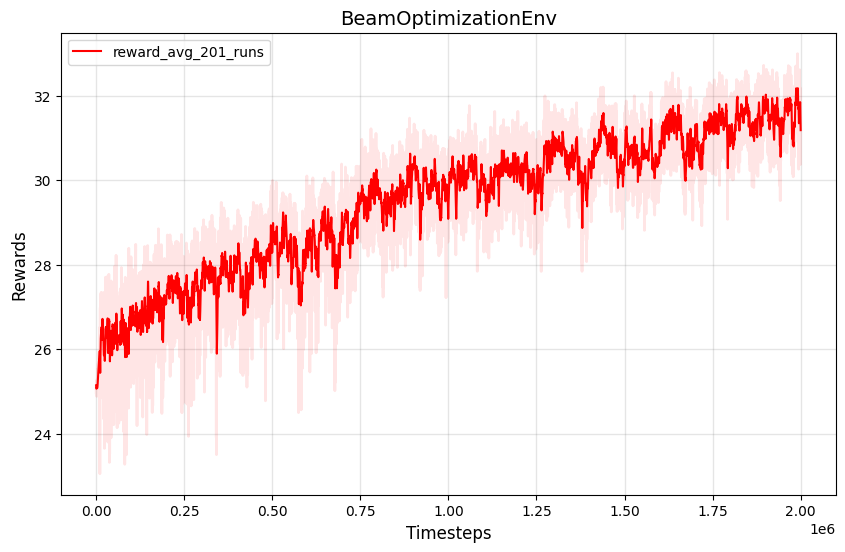

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

print("============================================================================================")

env_name = 'BeamOptimizationEnv'

fig_num = 0     #### change this to prevent overwriting figures in same env_name folder

plot_avg = True    # plot average of all runs; else plot all runs separately

fig_width = 10
fig_height = 6

# smooth out rewards to get a smooth and a less smooth (var) plot lines
window_len_smooth = 50
min_window_len_smooth = 1
linewidth_smooth = 1.5
alpha_smooth = 1

window_len_var = 5
min_window_len_var = 1
linewidth_var = 2
alpha_var = 0.1

colors = ['red', 'blue', 'green', 'orange', 'purple', 'olive', 'brown', 'magenta', 'cyan', 'crimson', 'gray', 'black']

# make directory for saving figures
figures_dir = "PPO_figs"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# make environment directory for saving figures
figures_dir = figures_dir + '/' + env_name + '/'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

fig_save_path = figures_dir + '/PPO_' + env_name + '_fig_' + str(fig_num) + '.png'

# get number of log files in directory
log_dir = "PPO_logs" + '/' + env_name + '/'
current_num_files = next(os.walk(log_dir))[2]
num_runs = len(current_num_files)

all_runs = []

for run_num in range(num_runs):
    log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"
    print("loading data from : " + log_f_name)
    if os.path.getsize(log_f_name) > 0:  # Check if the file is not empty
        data = pd.read_csv(log_f_name)
        data = pd.DataFrame(data)
        print("data shape : ", data.shape)
        all_runs.append(data)
    else:
        print(f"File {log_f_name} is empty. Skipping.")
    print("--------------------------------------------------------------------------------------------")

ax = plt.gca()

if plot_avg:
    # average all runs
    if all_runs:
        df_concat = pd.concat(all_runs)
        df_concat_groupby = df_concat.groupby(df_concat.index)
        data_avg = df_concat_groupby.mean()

        # smooth out rewards to get a smooth and a less smooth (var) plot lines
        data_avg['reward_smooth'] = data_avg['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
        data_avg['reward_var'] = data_avg['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

        data_avg.plot(kind='line', x='timestep', y='reward_smooth', ax=ax, color=colors[0], linewidth=linewidth_smooth, alpha=alpha_smooth)
        data_avg.plot(kind='line', x='timestep', y='reward_var', ax=ax, color=colors[0], linewidth=linewidth_var, alpha=alpha_var)

        # keep only reward_smooth in the legend and rename it
        handles, labels = ax.get_legend_handles_labels()
        ax.legend([handles[0]], ["reward_avg_" + str(len(all_runs)) + "_runs"], loc=2)
    else:
        print("No data available to plot.")
else:
    for i, run in enumerate(all_runs):
        # smooth out rewards to get a smooth and a less smooth (var) plot lines
        run['reward_smooth_' + str(i)] = run['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
        run['reward_var_' + str(i)] = run['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

        # plot the lines
        run.plot(kind='line', x='timestep', y='reward_smooth_' + str(i), ax=ax, color=colors[i % len(colors)], linewidth=linewidth_smooth, alpha=alpha_smooth)
        run.plot(kind='line', x='timestep', y='reward_var_' + str(i), ax=ax, color=colors[i % len(colors)], linewidth=linewidth_var, alpha=alpha_var)

    # keep alternate elements (reward_smooth_i) in the legend
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    new_labels = []
    for i in range(len(handles)):
        if i % 2 == 0:
            new_handles.append(handles[i])
            new_labels.append(labels[i])
    ax.legend(new_handles, new_labels, loc=2)

# ax.set_yticks(np.arange(0, 1800, 200))
# ax.set_xticks(np.arange(0, int(4e6), int(5e5)))

ax.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)

ax.set_xlabel("Timesteps", fontsize=12)
ax.set_ylabel("Rewards", fontsize=12)

plt.title(env_name, fontsize=14)

fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)

print("============================================================================================")

plt.savefig(fig_save_path)
print("figure saved at : ", fig_save_path)

print("============================================================================================")

plt.show()


Loading network from: PPO_preTrained/BeamOptimizationEnv/PPO_BeamOptimizationEnv_0_0.pth


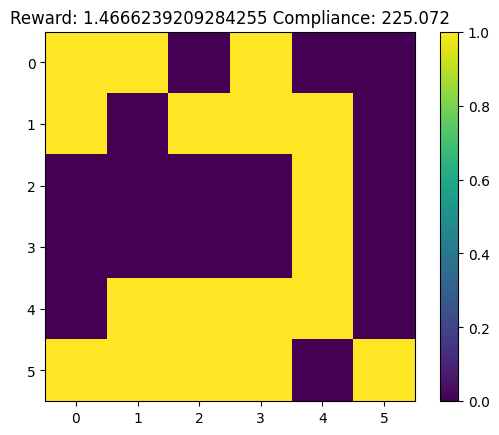

Episode: 1 		 Reward: 33.15


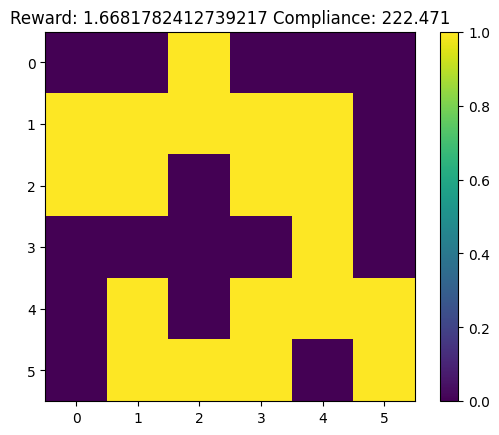

Episode: 2 		 Reward: 32.42


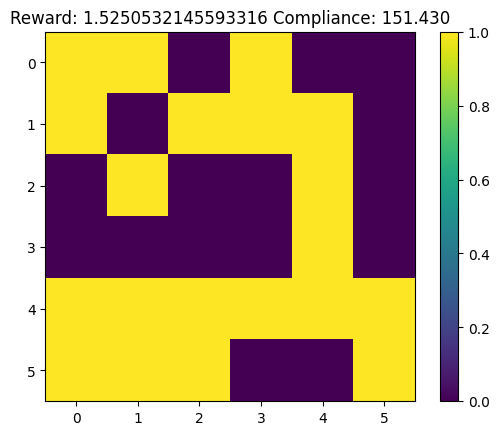

Episode: 3 		 Reward: 31.33


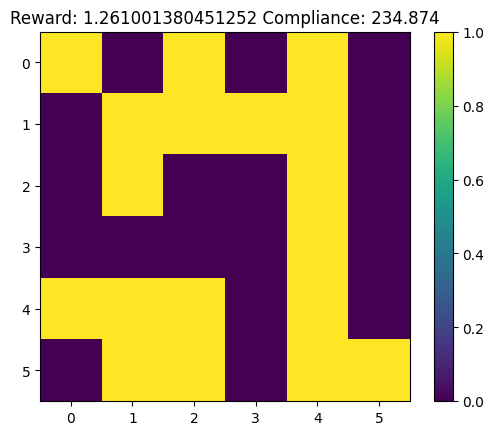

Episode: 4 		 Reward: 33.04


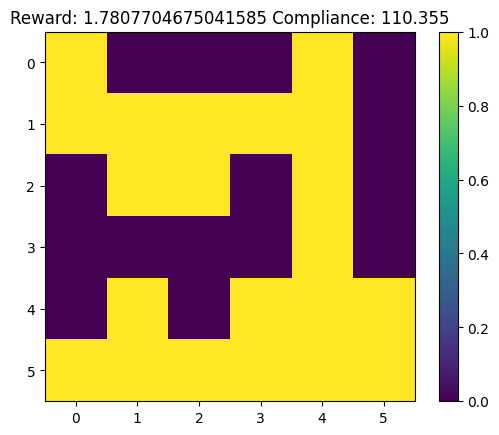

Episode: 5 		 Reward: 31.12


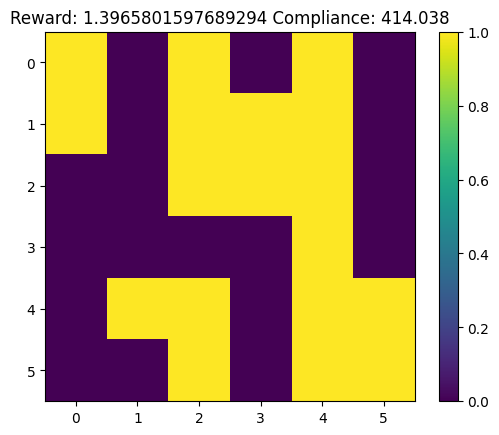

Episode: 6 		 Reward: 32.25


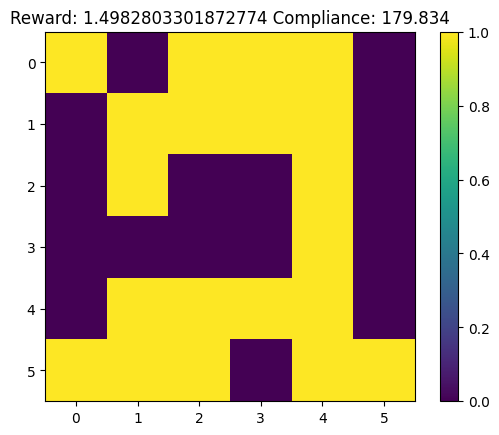

Episode: 7 		 Reward: 28.93


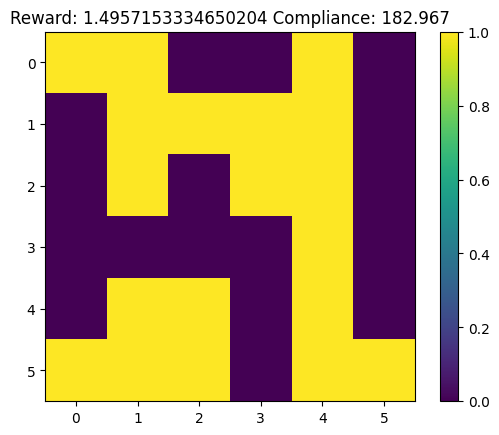

Episode: 8 		 Reward: 31.98


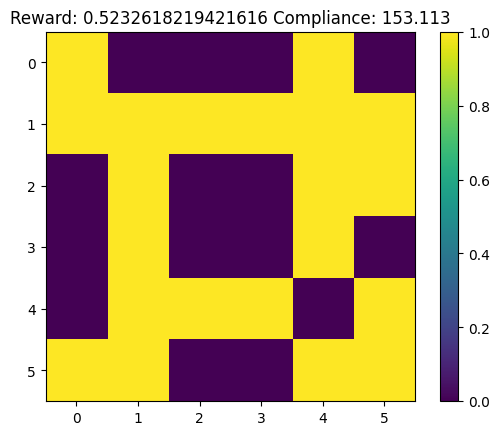

Episode: 9 		 Reward: 30.25


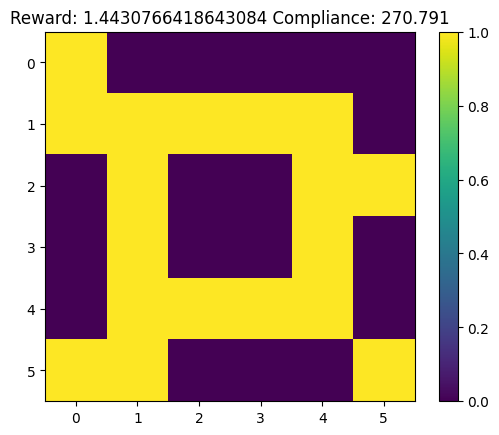

Episode: 10 		 Reward: 32.77


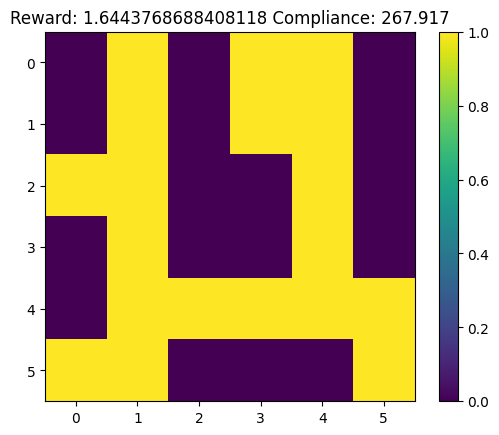

Episode: 11 		 Reward: 32.18


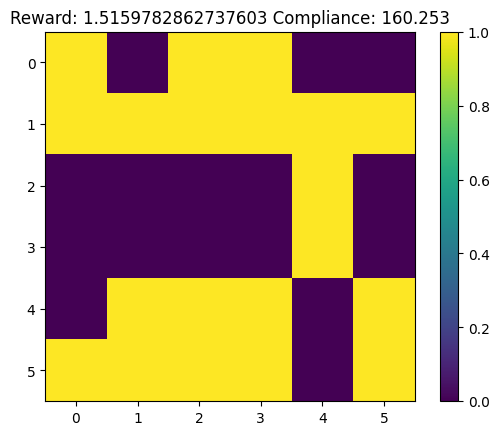

Episode: 12 		 Reward: 30.88


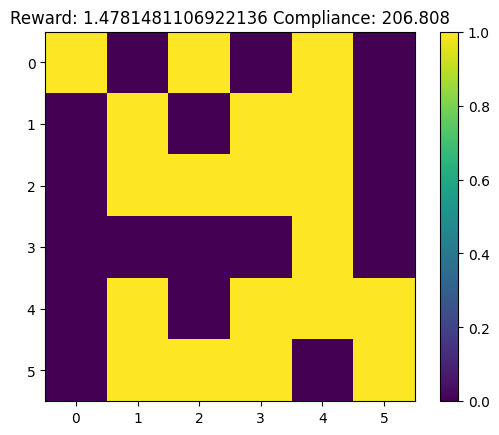

Episode: 13 		 Reward: 31.96


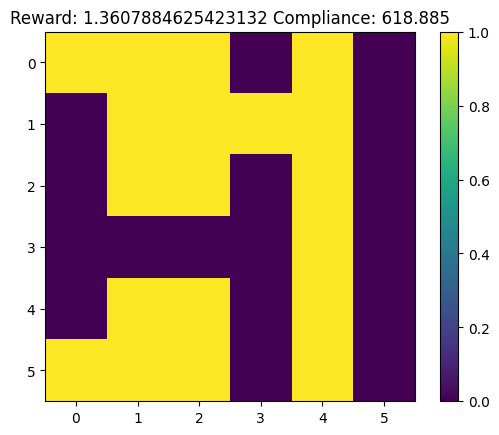

Episode: 14 		 Reward: 31.82


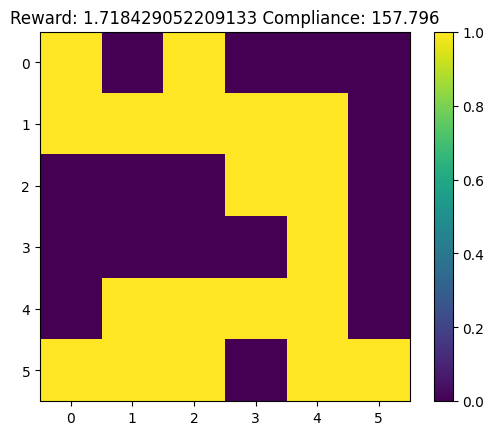

Episode: 15 		 Reward: 32.01


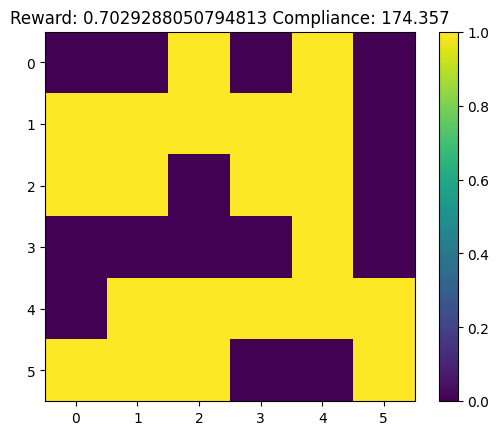

Episode: 16 		 Reward: 30.66


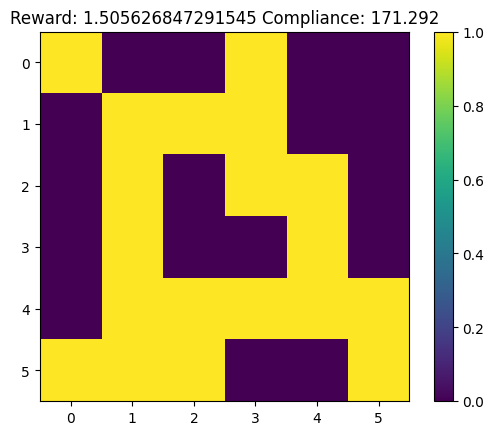

Episode: 17 		 Reward: 31.93


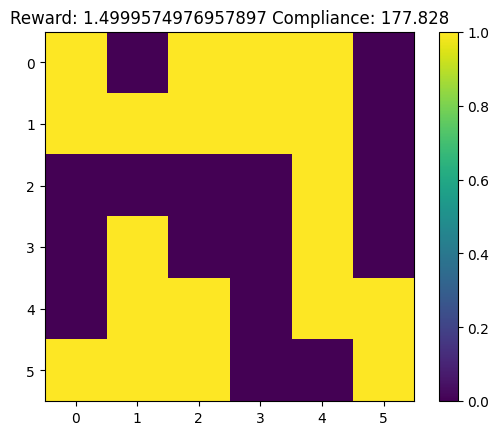

Episode: 18 		 Reward: 30.46


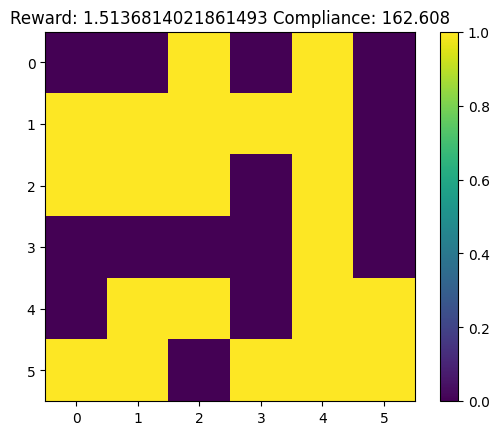

Episode: 19 		 Reward: 29.3
Average test reward: 59.84


In [ ]:
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt

# Assuming BeamOptimizationEnv, PPO, ActorCritic, and RolloutBuffer classes are defined elsewhere and imported

# Hyperparameters for inference
env_name = "BeamOptimizationEnv"
has_continuous_action_space = False
max_ep_len = 400
total_inference_episodes = 10  # Total number of inference episodes

# Initialize environment
env = BeamOptimizationEnv()

# State and action space dimensions
state_dim = env.observation_space.shape[0]
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n

# Initialize PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor=0.0003, lr_critic=0.001, gamma=0.99, K_epochs=80, eps_clip=0.2, has_continuous_action_space=has_continuous_action_space)

# Load pre-trained model
random_seed = 0             # Set this to load a particular checkpoint trained on a specific random seed
run_num_pretrained = 0      # Set this to load a particular checkpoint number
checkpoint_path = f"PPO_preTrained/{env_name}/PPO_{env_name}_{random_seed}_{run_num_pretrained}.pth"
print(f"Loading network from: {checkpoint_path}")
ppo_agent.load(checkpoint_path)

# Run inference
test_running_reward = 0
for ep in range(1,20):
    state = env.reset()
    ep_reward = 0

    for t in range(1, max_ep_len*3 + 1):
        action = ppo_agent.select_action(state)
        state, reward, done, truncated, _ = env.step(action)
        ep_reward += reward
        
        # Render the environment (visualize the current state)
        #env.render()
        
        if done:
            env.render()
            break

    test_running_reward += ep_reward
    print(f'Episode: {ep} \t\t Reward: {round(ep_reward, 2)}')

avg_test_reward = test_running_reward / total_inference_episodes
print(f"Average test reward: {avg_test_reward:.2f}")

# Close the environment after inference
env.close()
